In [1]:
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
n_rows = 200000 # Due to data quality, we only read first 2m rows
n_sample = 200000
category_path = "./data/Anno/list_category_cloth.txt"
img_path = "./data/Anno/list_category_img.txt"
bbox_path = "./data/Anno/list_bbox.txt"
partition_path = "./data/Eval/list_eval_partition.txt"
train_path = "./data/train_labels.csv"
test_path = "./data/test_labels.csv"

In [3]:
# Load cloth label and category mapping table
dt_category = pd.read_csv(category_path, sep=r'\s{1,}', skiprows=1, engine='python')
# Create category labels 
dt_category['category_label'] = np.arange(len(dt_category))+1

# Load image to category label mapping table
dt_img = pd.read_csv(img_path, sep=r'\s{1,}', skiprows=2, engine='python', header=None, 
                     nrows = n_rows, names=['image_name', 'category_label'])

# Load bounding box labels
dt_bbox = pd.read_csv(bbox_path, sep=r'\s{1,}', skiprows=2, engine='python', header=None, 
                      nrows = n_rows, names=['image_name', 'x_1', 'y_1', 'x_2', 'y_2'])

# Load train, test, eval partition list
dt_partition = pd.read_csv(partition_path, skiprows=2, sep=r'\s{2,}', engine='python', header=None, 
                           nrows = n_rows, names=['image_name', 'evaluation_status'])

In [4]:
# Create a summary table with following fields for training
# evaluation_status: train, test, eval
# filename: image file path
# class: image categories
# xmin: x coordinate of top left point of bounding box
# ymin: y coordinate of top left point of bounding box
# xmax: x coordinate of bottom right point of bounding box
# ymax: y coordinate of bottom right point of bounding box
dt_main = pd.merge(dt_partition, dt_bbox, left_on='image_name', right_on='image_name', how='inner')
dt_main = pd.merge(dt_main, dt_img, left_on='image_name', right_on='image_name', how='inner')
dt_main = pd.merge(dt_main, dt_category, left_on='category_label', right_on='category_label', how='inner')
# Only include top categories
dt_main = dt_main[dt_main.category_name.isin(['Blouse', 'Shorts', 'Skirt', 'Sweater', 'Tank', 'Tee'])]

In [5]:
# Get a sample of all images
dt_sample = dt_main.sample(n=n_sample).reset_index()
dt_sample = dt_sample[['evaluation_status', 'image_name', 'category_name', 'x_1','y_1','x_2','y_2']]
dt_sample.columns = ['evaluation_status','filename','class','xmin', 'ymin', 'xmax','ymax']
dt_sample.head()

,evaluation_status,filename,class,xmin,ymin,xmax,ymax
0,train,img/Texture-Striped_Mini_Skirt/img_00000042.jpg,Skirt,28,105,123,181
1,train,img/Striped_Crew_Neck_Tee/img_00000021.jpg,Tee,1,4,200,250
2,train,img/Striped_V-Neck_Jersey_Tee/img_00000045.jpg,Tee,1,1,300,300
3,train,img/Heart_Print_Boxy_Tee/img_00000036.jpg,Tee,85,91,237,242
4,train,img/TMNT_Graphic_Tee/img_00000068.jpg,Tee,122,3,300,187


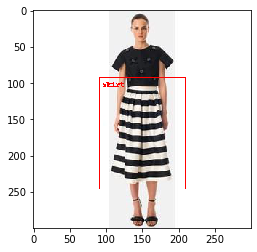

In [6]:
# Inspect images and bounding box 
img_idx = np.random.randint(dt_sample.shape[0])
img_path = './data/' + dt_sample['filename'][img_idx]
source_img = Image.open(img_path)
draw = ImageDraw.Draw(source_img)
draw.rectangle(((int(dt_sample['xmin'][img_idx]), int(dt_sample['ymin'][img_idx])), 
                (int(dt_sample['xmax'][img_idx]), int(dt_sample['ymax'][img_idx]))), 
               outline='red')
draw.text((int(dt_sample['xmin'][img_idx])+5, int(dt_sample['ymin'][img_idx])+5), 
          dt_sample['class'][img_idx], fill='red')
del draw
imshow(np.asarray(source_img))

In [7]:
# Export training & test summary tables
dt_sample[dt_sample.evaluation_status == 'train'].to_csv(train_path, index = False, header = True)
dt_sample[dt_sample.evaluation_status != 'train'].to_csv(test_path, index = False, header = True)